# НИР ОАД
## Система рекомендаций аниме v3

Доработанная и улучшенная система рекомандаций аниме по предпочтениям

![Схема](./anime-sch.png)

### Загружаем данные просмотров с Shikimori

Список просмотренных аниме пользователя

In [1]:
# Download personal anime list
!wget -O my_anime.xml https://shikimori.one/snipghost/list_export/animes.xml

--2021-12-29 02:48:54--  https://shikimori.one/snipghost/list_export/animes.xml
Распознаётся shikimori.one (shikimori.one)… 104.21.15.138, 172.67.162.171
Подключение к shikimori.one (shikimori.one)|104.21.15.138|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных [application/xml]
Сохранение в: «my_anime.xml»

my_anime.xml            [ <=>                ] 312,25K  --.-KB/s    за 0,02s   

2021-12-29 02:48:55 (15,6 MB/s) - «my_anime.xml» сохранён [319745]



### Базу данных аниме с Kaggle

In [2]:
# Download anime recommendations database
!kaggle datasets download --force CooperUnion/anime-recommendations-database -f anime.csv

100%|████████████████████████████████████████| 915k/915k [00:00<00:00, 6.02MB/s]
100%|████████████████████████████████████████| 915k/915k [00:00<00:00, 5.95MB/s]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn import preprocessing

In [4]:
df = pd.read_csv('anime.csv')
print(df.shape)
df.head()

(12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Anime.csv

    anime_id - myanimelist.net's unique id identifying an anime.
    name - full name of anime.
    genre - comma separated list of genres for this anime.
    type - movie, TV, OVA, etc.
    episodes - how many episodes in this show. (1 if movie).
    rating - average rating out of 10 for this anime.
    members - number of community members that are in this anime's "group".


### Очищаем выборку

Оставим аниме без указания жанра и типа, посколько далее применим one-hot-encoding к данному критерию

In [5]:
df['genre'] = df['genre'].fillna('Unknown')
df['type'] = df['type'].fillna('Unknown')
df['members'] = df['members'].fillna(0)

Заменим неизвестное количество эпизодов на 1, поскольку это позволит сохранить тайтл в списке и при этом является модой ряда, что незначительно повлияет на выборку.

Эмпирическое наблюдение: если число эпизодов неизвестно, это либо тайтл, который еще не вышел, а соответственно не имеет рейтинга и будет удален из выборки, либо аниме-фильм (1 серия).

In [6]:
mode = df['episodes'].mode()[0]
print(mode)

1


In [7]:
df['episodes'] = df['episodes'].replace('Unknown', mode)

In [8]:
df['episodes'].unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       '39', '101', '47', '50', '62', '33', '112', '23', '3', '94', '6',
       '8', '14', '7', '40', '15', '203', '77', '291', '120', '102', '96',
       '38', '79', '175', '103', '70', '153', '45', '5', '21', '63', '52',
       '28', '145', '36', '69', '60', '178', '114', '35', '61', '34',
       '109', '20', '9', '49', '366', '97', '48', '78', '358', '155',
       '104', '113', '54', '167', '161', '42', '142', '31', '373', '220',
       '46', '195', '17', '1787', '73', '147', '127', '16', '19', '98',
       '150', '76', '53', '124', '29', '115', '224', '44', '58', '93',
       '154', '92', '67', '172', '86', '30', '276', '59', '72', '330',
       '41', '105', '128', '137', '56', '55', '65', '243', '193', '18',
       '191', '180', '91', '192', '66', '182', '32', '164', '100', '296',
       '694', '95', '68', '117', '151', '130', '87', '170

### Оценим число пустых ячеек и удаляем лишние

In [9]:
df1 = df[df.isna().any(axis=1)]
df1.shape

(230, 7)

In [10]:
df1.head()

,anime_id,name,genre,type,episodes,rating,members
8968,34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,1,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,1,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,1,NaN,90706
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",Unknown,1,NaN,60999


In [11]:
print(df.shape)
df = df.dropna()
print(df.shape)
df.reset_index(drop=True, inplace=True)
df.head()

(12294, 7)
(12064, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


### Проводим нормализацию

In [12]:
def normalize(df, cols):
    x = df[cols]
    print(x.shape)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    print(x_scaled)
    print(x_scaled.shape)
    dataset = pd.DataFrame(x_scaled, columns = cols)
    print(dataset.shape)
    print(dataset.tail())
    #origin_columns = df.columns
    #df = df.drop(columns=cols)
    #df = pd.concat([df, dataset], ignore_index=True, axis=1)
    #df.columns = origin_columns
    for col in cols:
        df[col] = dataset[col]
    return df

In [13]:
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
df = df.fillna(df.mean())
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [14]:
df = normalize(df, ['rating', 'members', 'episodes'])
df.head()

(12064, 3)
[[9.24369748e-01 1.97866664e-01 0.00000000e+00]
 [9.11164466e-01 7.82768603e-01 3.46725371e-02]
 [9.09963986e-01 1.12683141e-01 2.75178866e-02]
 ...
 [3.85354142e-01 2.04161139e-04 1.65107320e-03]
 [3.97358944e-01 1.60764569e-04 0.00000000e+00]
 [4.54981993e-01 1.28217141e-04 0.00000000e+00]]
(12064, 3)
(12064, 3)
         rating   members  episodes
12059  0.297719  0.000196  0.000000
12060  0.313325  0.000169  0.000000
12061  0.385354  0.000204  0.001651
12062  0.397359  0.000161  0.000000
12063  0.454982  0.000128  0.000000


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,0.000000,0.924370,0.197867
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,0.034673,0.911164,0.782769
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,0.027518,0.909964,0.112683
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,0.012658,0.900360,0.664323
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,0.027518,0.899160,0.149180


### Проводим кодирование категориальных признаков

В прошлых реализациях лучше всего себя показал one hot encoding

In [15]:
def one_hot_encoding(df, cols):
    for col, col_type in cols:
        if col_type == list:
            col_data = df[col].str.split(', ')
            mlb = MultiLabelBinarizer()
        else:
            col_data = df[col]
            mlb = LabelBinarizer()
        mlb_data = mlb.fit_transform(col_data)
        encoded_data = pd.DataFrame(mlb_data, columns=mlb.classes_, index=col_data.index)
        
        for cls in mlb.classes_:
            if cls in df.columns.values:
                df = df.rename(columns={cls: '{}_{}'.format(cls, col)})
        
        print('Changing column: {} to: {}'.format(col, mlb.classes_))
        df = df.drop(columns=[col])
        df = pd.concat([df, encoded_data], axis=1)
    return df

In [16]:
df = one_hot_encoding(df, [('type', str), ('genre', list)])
# df = one_hot_encoding(df, [('genre', list)])
df = df.drop(columns=['Hentai', 'Yaoi', 'Yuri'])
df.head()

Changing column: type to: ['Movie' 'Music' 'ONA' 'OVA' 'Special' 'TV']
Changing column: genre to: ['Action' 'Adventure' 'Cars' 'Comedy' 'Dementia' 'Demons' 'Drama' 'Ecchi'
 'Fantasy' 'Game' 'Harem' 'Hentai' 'Historical' 'Horror' 'Josei' 'Kids'
 'Magic' 'Martial Arts' 'Mecha' 'Military' 'Music' 'Mystery' 'Parody'
 'Police' 'Psychological' 'Romance' 'Samurai' 'School' 'Sci-Fi' 'Seinen'
 'Shoujo' 'Shoujo Ai' 'Shounen' 'Shounen Ai' 'Slice of Life' 'Space'
 'Sports' 'Super Power' 'Supernatural' 'Thriller' 'Unknown' 'Vampire'
 'Yaoi' 'Yuri']


,anime_id,name,episodes,rating,members,Movie,Music_genre,ONA,OVA,Special,...,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire
0,32281,Kimi no Na wa.,0.000000,0.924370,0.197867,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,0.034673,0.911164,0.782769,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,0.027518,0.909964,0.112683,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,0.012658,0.900360,0.664323,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,9969,Gintama&#039;,0.027518,0.899160,0.149180,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Проводим анализ корреляций

In [17]:
def plot_corr_matrix(df,size=15):
    corr = df.corr().abs()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.xticks(rotation=90)
    return corr

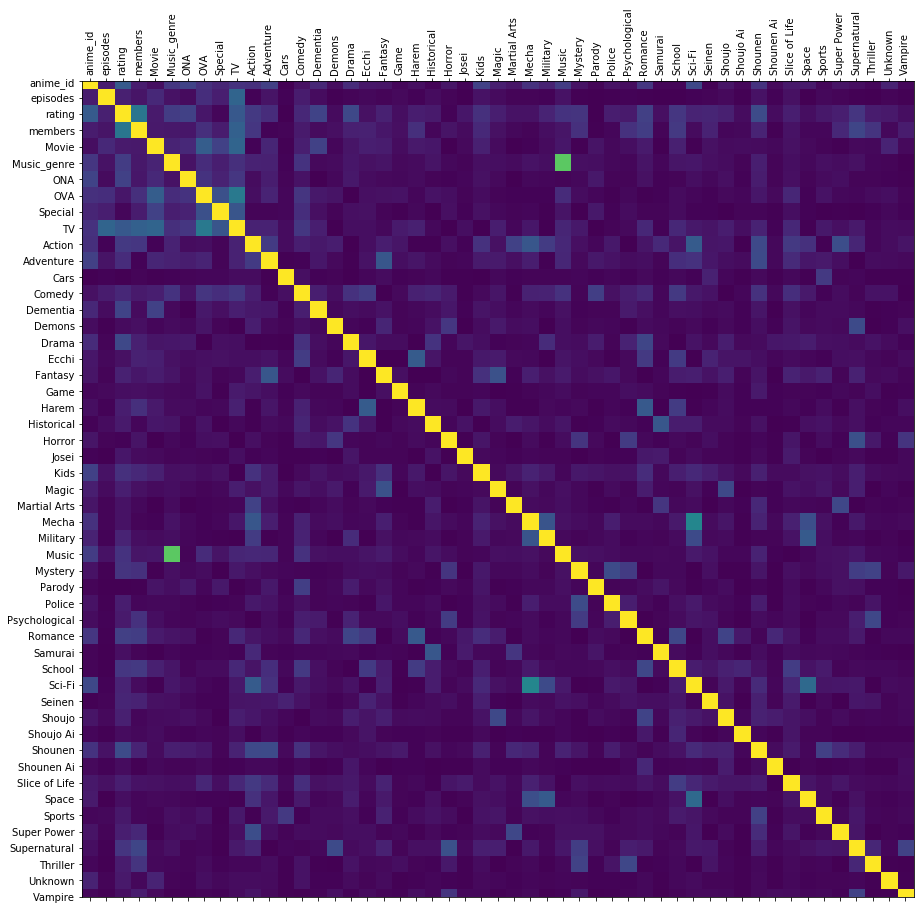

In [18]:
corr = plot_corr_matrix(df)

### Удаляем паразитные корреляции

In [19]:
def drop_correlated(df, corr_matrix, threshold=0.5):
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
    df = df.drop(columns=to_drop)
    return df

In [20]:
df = drop_correlated(df, corr)
df.head()

,anime_id,name,episodes,rating,members,Movie,Music_genre,ONA,OVA,Special,...,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire
0,32281,Kimi no Na wa.,0.000000,0.924370,0.197867,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,0.034673,0.911164,0.782769,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,0.027518,0.909964,0.112683,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,0.012658,0.900360,0.664323,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,9969,Gintama&#039;,0.027518,0.899160,0.149180,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


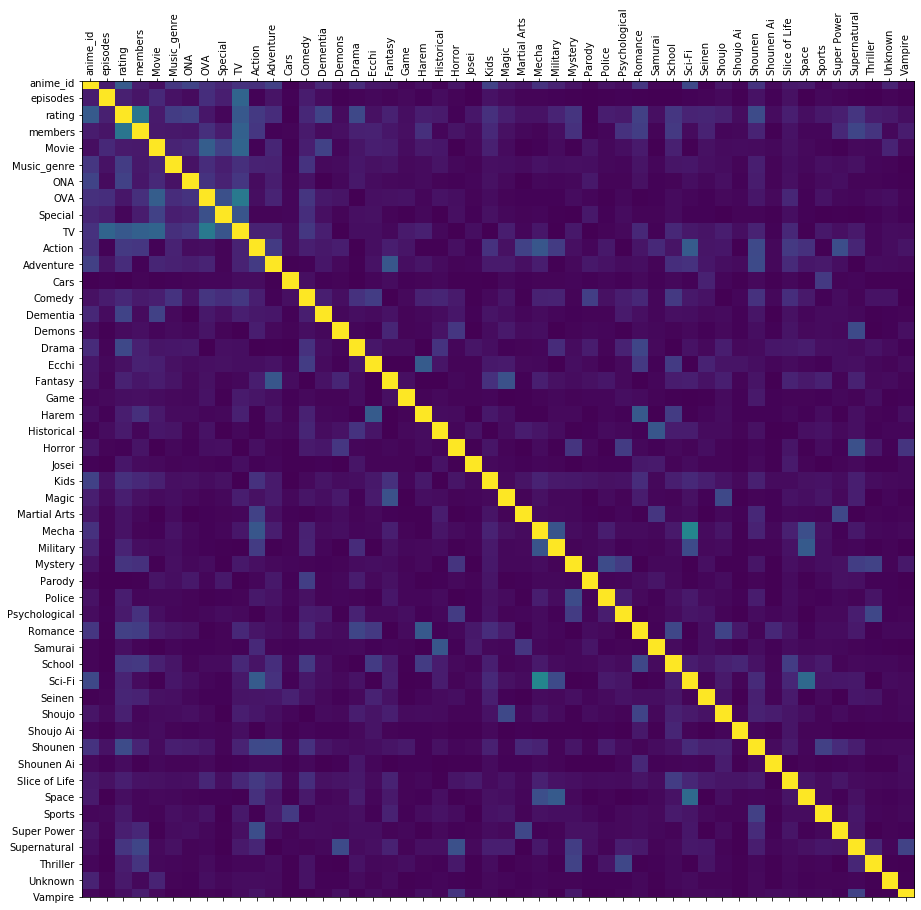

In [21]:
corr = plot_corr_matrix(df)

### Подготавливаем столбец для предсказания

In [22]:
df['user_rating'] = pd.Series(np.zeros(df.shape[0]))

In [23]:
import xml.etree.ElementTree as ET

tree = ET.parse('my_anime.xml')
root = tree.getroot()
anime_list = root.findall('anime')

for anime in anime_list:
    idx = anime.find('series_animedb_id')
    title = anime.find('series_title')
    score = anime.find('my_score')
    list_has = df['anime_id'] == float(idx.text)
    if not list_has.empty and float(score.text) != 0.0:
        df.loc[list_has, 'user_rating'] = float(score.text)
        
df.head()

,anime_id,name,episodes,rating,members,Movie,Music_genre,ONA,OVA,Special,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,user_rating
0,32281,Kimi no Na wa.,0.000000,0.924370,0.197867,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,10.0
1,5114,Fullmetal Alchemist: Brotherhood,0.034673,0.911164,0.782769,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
2,28977,Gintama°,0.027518,0.909964,0.112683,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,9253,Steins;Gate,0.012658,0.900360,0.664323,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,10.0
4,9969,Gintama&#039;,0.027518,0.899160,0.149180,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [24]:
df.loc[df['user_rating']>0].head()

,anime_id,name,episodes,rating,members,Movie,Music_genre,ONA,OVA,Special,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,user_rating
0,32281,Kimi no Na wa.,0.000000,0.924370,0.197867,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,10.0
1,5114,Fullmetal Alchemist: Brotherhood,0.034673,0.911164,0.782769,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
3,9253,Steins;Gate,0.012658,0.900360,0.664323,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,10.0
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,0.004953,0.897959,0.092059,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,7.0
7,820,Ginga Eiyuu Densetsu,0.059989,0.893157,0.079561,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,10.0


### Выводим наиболее значимые признаки

In [25]:
df.corr().abs()['user_rating'][:].sort_values(ascending=False).head(9)

user_rating    1.000000
members        0.398737
rating         0.169319
School         0.124823
Romance        0.091162
TV             0.088928
Thriller       0.077588
Military       0.063950
Harem          0.061144
Name: user_rating, dtype: float64

### Готовим данные к обучению

In [26]:
pred_val = 'user_rating'
c = list(df.columns)
c.remove('anime_id')
c.remove('name')
c.remove(pred_val)

e = df[pred_val] != 0.0
X_train = pd.DataFrame(df[e][c])
Y_train = pd.DataFrame(df[e][pred_val])
print(X_train.shape)

e = df[pred_val] == 0.0
X = pd.DataFrame(df[e][c])
print(X.shape)

(225, 49)
(11839, 49)


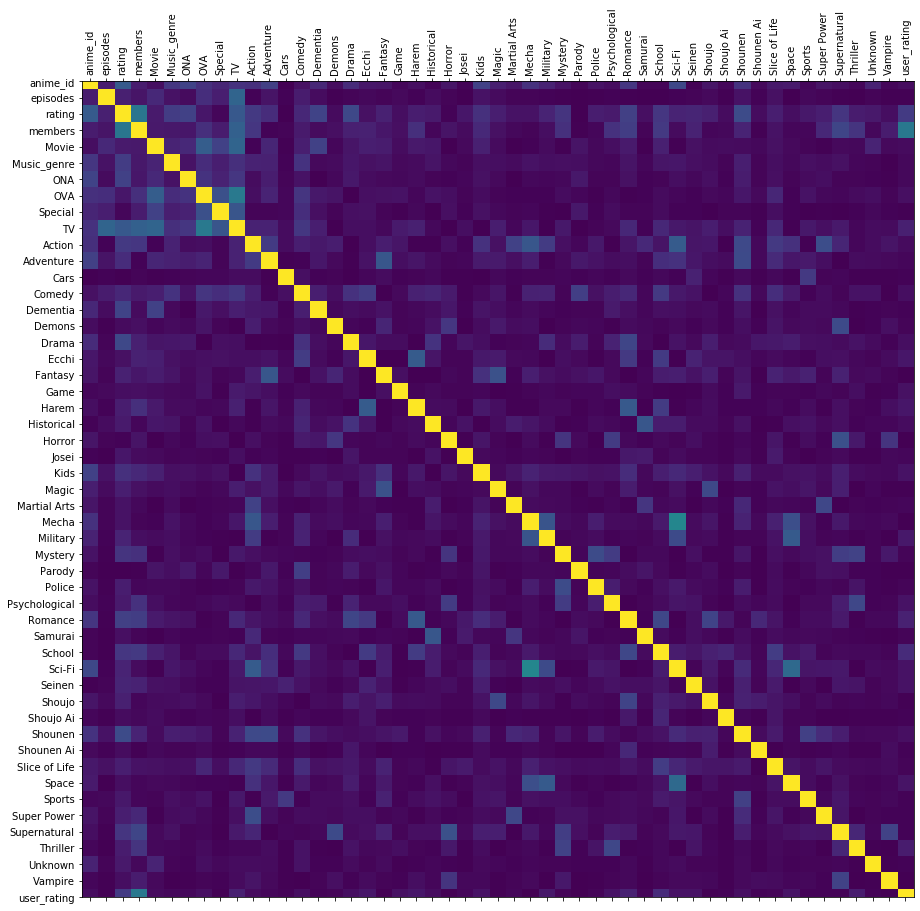

In [27]:
corr = plot_corr_matrix(df)

### Обучаем модели

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [29]:
def calc_scores(model, X, Y, test=None):
    if test is not None:
        Xr = X.iloc[test,:]
        Yr = Y.iloc[test,:]
    else:
        Xr = X
        Yr = Y
    Y_pred = model.predict(Xr)
    score_r2 = model.score(Xr, Yr.values.ravel())
    score_rmse = mean_squared_error(Yr, Y_pred)
    score_abs = mean_absolute_error(Yr, Y_pred)
    return (score_r2, score_rmse, score_abs)

In [30]:
def fit_predict(model, X_train, Y_train, X, rst=21, print_size=15):
    scores_1 = []
    scores_2 = []
    scores_3 = []
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=rst)
    for i, (train, test) in enumerate(kfold.split(X_train, Y_train)):
        model.fit(X_train.iloc[train,:], Y_train.iloc[train,:].values.ravel())
        scores = calc_scores(model, X_train, Y_train, test)
        scores_1.append(scores[0])
        scores_2.append(scores[1])
        scores_3.append(scores[2])

    model.fit(X_train, Y_train.values.ravel())
    
    scores = calc_scores(model, X_train, Y_train)
    scores_1.append(scores[0])
    scores_2.append(scores[1])
    scores_3.append(scores[2])
    
    x = np.arange(0, 6, 1)
    plt.plot(x, scores_1)
    plt.plot(x, scores_2)
    plt.plot(x, scores_3)
    labels = ['R2', 'RMSE', 'MAE']
    plt.legend(labels)
    plt.show()

    # Условие по которому вы выбираете TEST выборку
    # это может быть просто df.iloc[test,:] (срез)
    e = df[pred_val] == 0.0
    
    Y = pd.DataFrame(df[e])
    Y[pred_val] = model.predict(X)
    Y.sort_values(by=[pred_val], ascending=False)[['name', pred_val]].head(print_size)
    print(Y.sort_values(by=[pred_val], ascending=False)[['name', pred_val]].head(print_size))

In [31]:
models = [
    BayesianRidge(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
# Classificasion methods
#     LogisticRegression(),
#     MLPClassifier(),
]

In [32]:
def solve(models, X_train, Y_train, X):
    for model in models:
        print('Model:', type(model).__name__)
        fit_predict(model, X_train, Y_train, X)
        print('\n\n\n')

Model: BayesianRidge


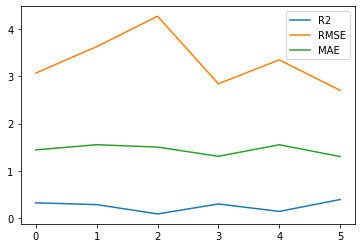

                               name  user_rating
38                          Monster     9.341352
1235                     Metropolis     9.021983
493                 Higashi no Eden     9.016313
832           Ima, Soko ni Iru Boku     8.676329
2902                    Blue Gender     8.467068
114            Sakamichi no Apollon     8.426265
132           Toki wo Kakeru Shoujo     8.404525
238                      Gankutsuou     8.388810
200             Fullmetal Alchemist     8.362683
1218          Uchuu Senkan Yamato 2     8.349703
2365        Giniro no Kami no Agito     8.299805
2213        Uchuu Senkan Yamato III     8.294208
1347  Uchuu no Kishi Tekkaman Blade     8.292628
365                         Paprika     8.289212
981                 Mousou Dairinin     8.272495




Model: RandomForestRegressor


/Users/snipghost/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


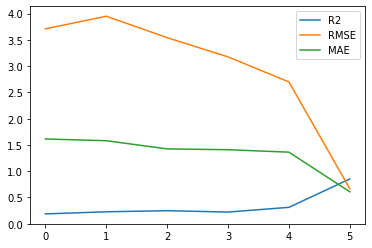

                                                 name  user_rating
45                     Kara no Kyoukai 5: Mujun Rasen          9.9
55       Tengen Toppa Gurren Lagann Movie: Lagann-hen          9.7
60                                 Hotarubi no Mori e          9.7
77         Kara no Kyoukai 7: Satsujin Kousatsu (Kou)          9.5
21  Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...          9.5
52                   Kamisama Hajimemashita: Kako-hen          9.4
89                                 Doukyuusei (Movie)          9.3
37                    Kizumonogatari II: Nekketsu-hen          9.3
8   Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...          9.1
85                 Mushishi Zoku Shou: Odoro no Michi          9.1
35                                Howl no Ugoku Shiro          9.1
18                       Ookami Kodomo no Ame to Yuki          9.1
50                             Yojouhan Shinwa Taikei          9.0
53                Rainbow: Nisha Rokubou no Shichinin         

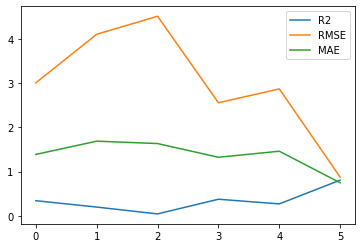

                                                  name  user_rating
45                      Kara no Kyoukai 5: Mujun Rasen     9.703963
38                                             Monster     9.598846
21   Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...     9.424610
68                       Shouwa Genroku Rakugo Shinjuu     9.347151
53                 Rainbow: Nisha Rokubou no Shichinin     9.217672
93                                       Chihayafuru 2     9.162242
60                                  Hotarubi no Mori e     9.089781
24                                       Mononoke Hime     9.072227
36                                Fate/Zero 2nd Season     9.059511
35                                 Howl no Ugoku Shiro     9.002769
10                                Clannad: After Story     9.001474
75     Ghost in the Shell: Stand Alone Complex 2nd GIG     8.915459
50                              Yojouhan Shinwa Taikei     8.660034
761                      Hachimitsu to Clover Sp

In [33]:
solve(models, X_train, Y_train, X)

Примечательно что все модели высоко оценивают тайтлы:

Kara no Kyoukai 5: Mujun Rasen  
Monster  
Hotarubi no Mori e  
Metropolis  

Которые находятся в моем списке "запланировано к просмотру"

## Выводы:

Эмпирически выявлено, что лучший результат дают регрессионные модели.

Из графиков RMSE-метрики следует, что модель GradientBoostingRegressor превосходит остальные.
Хоть все модели и выдали разные списки рекомендаций - они значительно пересекаются между собой, так все 4 модели прогнозируют высокую пользовательскую оценку аниме-сериалу Monster.
Причем рекоменации аниме значительно совпадают с моим собственным списком "запланировано к просмотру".